> Class

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer



# Data

In [5]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [6]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

# functions 

In [7]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [8]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [9]:
edges_tensor = torch.tensor(edges)

In [10]:
nonzero_indices = edges_tensor.nonzero()

In [11]:
fiveNet_edge = np.array(nonzero_indices).T

In [12]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [13]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [14]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

# Random Missing Values

In [15]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = self.df.copy()
        self.percent = percent
        for i in range(self.N):
            self.seed = np.random.choice(1000,1,replace=False)
            np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df)),int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

In [16]:
_zero = Missing(fiveVTS_train)

In [17]:
_zero.miss(percent = 0.5)

In [ ]:
vis(_zero.missing);

In [19]:
_zero.first_mean()

In [ ]:
vis(_zero.train_mean);

In [21]:
_zero.second_linear()

In [ ]:
vis(np.array(_zero.train_linear).reshape(160,5));

In [23]:
class Method:
    def __init__(self,df,time):
        self.df = df
        self.test_data = fiveVTS_test
        self.N = N
        self.time = time
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.node_features = node_features
        self.xt_test = torch.tensor(self.test_data.reshape(int(len(self.test_data)),self.N,1)[:-1,:,:]).float()
        self.w = np.zeros(((self.time-1)*self.N,(self.time-1)*self.N))
        self.mse = []
        self.mae = []
    def _weight(self):
        for i in range((self.time-1)*self.N):
            for j in range((self.time-1)*self.N):
                if i==j :
                    self.w[i,j] = 0
                elif np.abs(i-j) <= 1 : 
                    self.w[i,j] = 1
    def _STGCN(self):
        self.df2 = torch.tensor(self.df).reshape(self.time,self.N,1).float()
        self.X = self.df2[:self.time-1,:,:]
        self.y = self.df2[1:,:,:]
        model = RecurrentGCN(node_features=1, filters=4)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        model.train()
        for epoch in tqdm(range(50)):
            for time, (xt,yt) in enumerate(zip(self.X,self.y)):
                y_hat = model(xt, edge_index, edge_attr)
                cost = torch.mean((y_hat-yt)**2)
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
        self.train_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.X]).detach().numpy()
        self.test_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.xt_test]).detach().numpy()
        for i in range(self.N):
            self.mse.append(np.mean((self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])**2))
        for i in range(self.N):
            self.mae.append(np.mean(np.abs(self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])))
    def FT(self):
        self._weight()
        self._STGCN()
        self.d = np.array(self.w.sum(axis=1))
        self.D = np.diag(self.d)
        self.L = np.array(np.diag(1/np.sqrt(self.d)) @ (self.D-self.w) @ np.diag(1/np.sqrt(self.d)))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)
        self.fhatbar = self.Psi.T @ self.train_result.reshape((self.time-1)*self.N,1)
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.fhatbar_threshed = ebayesthresh(FloatVector(self.fhatbar))
        self.fhatbarhat = self.Psi @ self.fhatbar_threshed
        self.FT_result = self.fhatbarhat.reshape((self.time-1),self.N,1)

# missing: 50%

## Mean

mean result

In [ ]:
vis(_zero.train_mean);

In [25]:
_two = Method(_zero.train_mean,160)

In [26]:
_two.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],_two.test_result);

In [ ]:
vis2(_zero.train_mean,_two.train_result);

Ebayes result

In [ ]:
plt.plot(_two.fhatbar)
plt.plot(_two.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,_two.FT_result.reshape(159,5));

In [31]:
_three = Method(_two.FT_result,159)

In [32]:
_three.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],_three.test_result);

In [ ]:
vis2(_zero.train_mean,_three.train_result);

Ebayes result

In [ ]:
plt.plot(_three.fhatbar)
plt.plot(_three.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,_three.FT_result.reshape(158,5));

In [37]:
pd.DataFrame({'1':_two.mse,'2':_three.mse})

,1,2
0,1.127840,1.185874
1,1.136627,1.239555
2,1.041937,1.024299
3,0.873353,0.793870
4,1.581547,1.532444


In [38]:
pd.DataFrame({'1':_two.mae,'2':_three.mae})

,1,2
0,0.810725,0.833354
1,0.859093,0.889160
2,0.832850,0.847244
3,0.736444,0.699711
4,1.014850,1.000413


## Linear

In [ ]:
vis(np.array(_zero.train_linear).reshape(160,5));

In [40]:
__two = Method(_zero.train_linear,160)

In [41]:
__two.FT()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],__two.test_result);

In [ ]:
vis2(_zero.train_linear,__two.train_result);

Ebayes result

In [ ]:
plt.plot(__two.fhatbar)
plt.plot(__two.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,__two.FT_result.reshape(159,5));

In [46]:
__three = Method(__two.FT_result,159)

In [47]:
__three.FT()

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],__three.test_result);

In [ ]:
vis2(_zero.train_linear,__three.train_result);

Ebayes result

In [ ]:
plt.plot(__three.fhatbar)
plt.plot(__three.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,__three.FT_result.reshape(158,5));

In [52]:
pd.DataFrame({'1':__two.mse,'2':__three.mse})

,1,2
0,1.281765,1.400721
1,1.486607,1.592832
2,1.113505,1.165222
3,0.940647,0.923844
4,1.392708,1.508399


In [53]:
pd.DataFrame({'1':__two.mae,'2':__three.mae})

,1,2
0,0.900372,0.917123
1,0.958798,1.001564
2,0.877698,0.912896
3,0.777983,0.791293
4,0.959073,1.004081


# missing : 40%

In [54]:
__zero = Missing(fiveVTS_train)

In [55]:
__zero.miss(percent = 0.4)

In [56]:
__zero.first_mean()

In [57]:
__zero.second_linear()

## Mean

In [58]:
_two1 = Method(__zero.train_mean,160)

In [59]:
_two1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],_two1.test_result);

In [ ]:
vis2(_zero.train_mean,_two1.train_result);

Ebayes result

In [ ]:
plt.plot(_two1.fhatbar)
plt.plot(_two1.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,_two1.FT_result.reshape(159,5));

In [64]:
_three1 = Method(_two1.FT_result,159)

In [65]:
_three1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],_three1.test_result);

In [ ]:
vis2(_zero.train_mean,_three1.train_result);

Ebayes result

In [ ]:
plt.plot(_three1.fhatbar)
plt.plot(_three1.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,_three1.FT_result.reshape(158,5));

In [70]:
_four1 = Method(_three1.FT_result,158)

In [71]:
_four1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


ST-GCN

In [ ]:
vis2(fiveVTS_test[1:],_four1.test_result);

In [ ]:
vis2(_zero.train_mean,_four1.train_result);

Ebayes result

In [ ]:
plt.plot(_four1.fhatbar)
plt.plot(_four1.fhatbar_threshed)

Inverse FT result

In [ ]:
vis2(_zero.train_mean,_four1.FT_result.reshape(157,5));

In [76]:
_five1 = Method(_four1.FT_result,157)

In [77]:
_five1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [78]:
pd.DataFrame({'1':_two1.mse,'2':_three1.mse,'3':_four1.mse,'4':_five1.mse})

,1,2,3,4
0,1.168309,1.230553,1.192988,1.175019
1,1.066498,1.276368,1.177094,1.171697
2,1.010410,1.012038,1.015355,1.067709
3,0.778463,0.888485,0.769993,0.772112
4,1.423373,1.625111,1.490132,1.584657


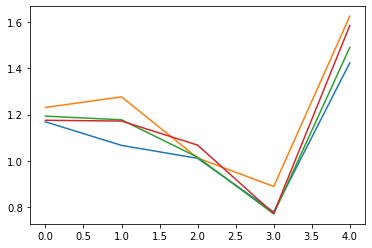

In [79]:
plt.plot(pd.DataFrame({'1':_two1.mse,'2':_three1.mse,'3':_four1.mse,'4':_five1.mse}))

In [80]:
pd.DataFrame({'1':_two1.mae,'2':_three1.mae,'3':_four1.mae,'4':_five1.mae})

,1,2,3,4
0,0.799169,0.864659,0.826029,0.829156
1,0.850051,0.903948,0.878605,0.868525
2,0.861471,0.824245,0.852739,0.869433
3,0.678440,0.752933,0.675502,0.674261
4,0.986608,1.034750,0.997042,1.016092


In [ ]:
vis2(fiveVTS_test[1:],_two1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_three1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_four1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_five1.test_result);

## Linear

In [85]:
__two1 = Method(__zero.train_linear,160)

In [86]:
__two1.FT()

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [87]:
__three1 = Method(__two1.FT_result,159)

In [88]:
__three1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [89]:
__four1 = Method(__three1.FT_result,158)

In [90]:
__four1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [91]:
__five1 = Method(__four1.FT_result,157)

In [92]:
__five1.FT()

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [93]:
pd.DataFrame({'1':__two1.mse,'2':__three1.mse,'3':__four1.mse,'4':__five1.mse})

,1,2,3,4
0,1.322930,1.515256,1.433440,1.285924
1,1.392571,1.781884,1.672098,1.457686
2,1.064279,1.333298,1.263279,1.111698
3,0.850177,0.953438,0.938495,0.894633
4,1.383176,1.599101,1.574063,1.538558


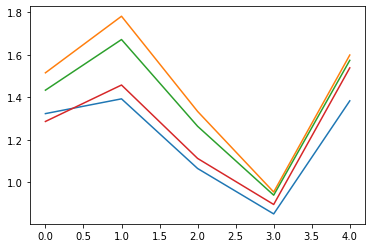

In [94]:
plt.plot(pd.DataFrame({'1':__two1.mse,'2':__three1.mse,'3':__four1.mse,'4':__five1.mse}))

In [95]:
pd.DataFrame({'1':__two1.mae,'2':__three1.mae,'3':__four1.mae,'4':__five1.mae})

,1,2,3,4
0,0.898631,0.958182,0.948353,0.867740
1,0.929860,1.050781,1.015666,0.972589
2,0.854576,0.975453,0.945135,0.883765
3,0.733181,0.808303,0.797947,0.770136
4,0.957883,1.028632,1.034039,1.012992


In [ ]:
vis2(fiveVTS_test[1:],__two1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__three1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__four1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__five1.test_result);

# missing : 70%

In [100]:
____zero = Missing(fiveVTS_train)

In [101]:
____zero.miss(percent = 0.7)

In [102]:
____zero.first_mean()

In [103]:
____zero.second_linear()

## Mean

In [104]:
_two3 = Method(____zero.train_mean,160)

In [105]:
_two3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [106]:
_three3 = Method(_two3.FT_result,159)

In [107]:
_three3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [108]:
_four3 = Method(_three3.FT_result,158)

In [109]:
_four3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [110]:
_five3 = Method(_four3.FT_result,157)

In [111]:
_five3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


In [112]:
pd.DataFrame({'1':_two3.mse,'2':_three3.mse,'3':_four3.mse,'4':_five3.mse})

,1,2,3,4
0,1.448017,1.364855,1.201664,1.213758
1,1.247535,1.253670,1.192967,1.163686
2,1.036282,1.106526,1.083865,1.088754
3,0.941918,0.934027,0.839766,0.874371
4,1.737001,1.859111,1.650749,1.680171


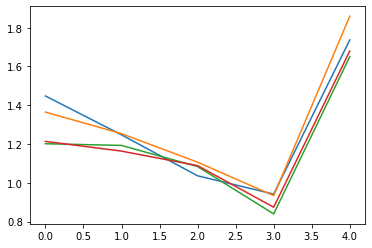

In [113]:
plt.plot(pd.DataFrame({'1':_two3.mse,'2':_three3.mse,'3':_four3.mse,'4':_five3.mse}))

In [114]:
pd.DataFrame({'1':_two3.mae,'2':_three3.mae,'3':_four3.mae,'4':_five3.mae})

,1,2,3,4
0,0.927395,0.927923,0.854297,0.858955
1,0.887239,0.895229,0.885876,0.882910
2,0.821978,0.853594,0.863880,0.855449
3,0.752587,0.759081,0.719327,0.727041
4,1.087924,1.113979,1.056868,1.065154


In [ ]:
vis2(fiveVTS_test[1:],_two3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_three3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_four3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_five3.test_result);

## Linear

In [119]:
__two3 = Method(____zero.train_linear,160)

In [120]:
__two3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [121]:
__three3 = Method(__two3.FT_result,159)

In [122]:
__three3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [123]:
__four3 = Method(__three3.FT_result,158)

In [124]:
__four3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [125]:
__five3 = Method(__four3.FT_result,157)

In [126]:
__five3.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [127]:
pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse})

,1,2,3,4
0,1.606461,1.560883,1.545523,1.497282
1,1.847612,1.941934,1.835855,1.759470
2,1.330572,1.329310,1.316518,1.261980
3,1.027761,0.999007,0.997890,1.029145
4,1.625325,1.592073,1.593470,1.626432


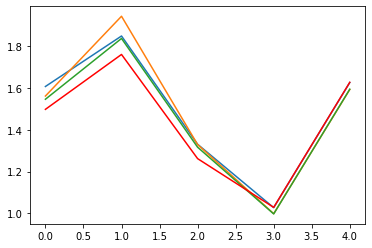

In [128]:
plt.plot(pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse}).iloc[:,:3])
plt.plot(pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse}).iloc[:,3:],'r')

# missing : 10%

In [129]:
___zero = Missing(fiveVTS_train)

In [130]:
___zero.miss(percent = 0.1)

In [131]:
___zero.first_mean()

In [132]:
___zero.second_linear()

## Mean

In [133]:
_two2 = Method(___zero.train_mean,160)

In [134]:
_two2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [135]:
_three2 = Method(_two2.FT_result,159)

In [136]:
_three2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [137]:
_four2 = Method(_three2.FT_result,158)

In [138]:
_four2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


In [139]:
pd.DataFrame({'1':_two2.mse,'2':_three2.mse,'3':_four2.mse})

,1,2,3
0,1.137904,1.157075,1.192053
1,1.167234,1.250587,1.265843
2,1.062204,0.993897,0.995095
3,0.779682,0.814248,0.823841
4,1.362454,1.477629,1.510099


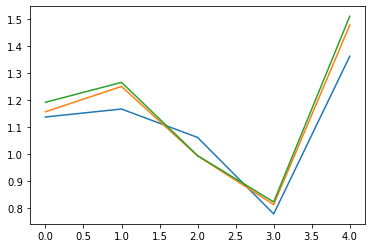

In [140]:
plt.plot(pd.DataFrame({'1':_two2.mse,'2':_three2.mse,'3':_four2.mse}))

## Linear

In [141]:
__two2 = Method(__zero.train_linear,160)

In [142]:
__two2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [143]:
__three2 = Method(__two2.FT_result,159)

In [144]:
__three2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [145]:
__four2 = Method(__three2.FT_result,158)

In [146]:
__four2.FT()

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [147]:
pd.DataFrame({'1':__two2.mse,'2':__three2.mse,'3':__four2.mse})

,1,2,3
0,1.276037,1.489909,1.427462
1,1.454765,1.681969,1.715689
2,1.104015,1.232047,1.253699
3,0.899755,0.944587,0.947889
4,1.403635,1.535966,1.551348


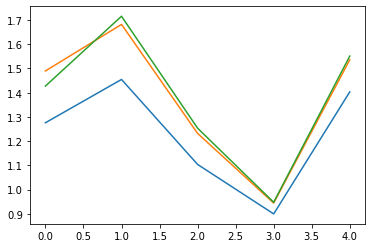

In [148]:
plt.plot(pd.DataFrame({'1':__two2.mse,'2':__three2.mse,'3':__four2.mse}))

# missing 50%, 100번 반복

In [149]:
ttt = 160
_mse = []
_mae = []
b = _zero.train_mean
for i in range(10):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result

100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


In [163]:
pd.DataFrame(_mse)

,0,1,2,3,4
0,1.215264,1.130562,1.011061,0.865932,1.568760
1,1.167962,1.195388,1.078493,0.804420,1.600873
2,1.244877,1.246561,1.011490,0.894555,1.664314
3,1.286138,1.223481,1.046993,0.963138,1.749391
4,1.444881,1.206482,1.136445,1.076626,2.002398
5,1.318931,1.157787,1.105601,0.976272,1.853680
6,1.223204,1.194855,1.050819,0.819947,1.606285
7,1.250604,1.137884,1.083863,0.895662,1.713069
8,1.361681,1.142422,1.129934,0.974136,1.841398
9,1.386397,1.144774,1.159029,1.039915,1.963435


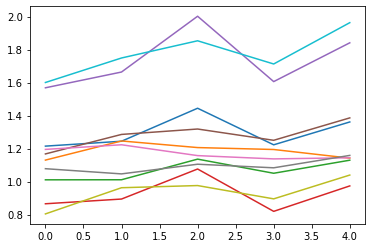

In [158]:
plt.plot(np.array(_mse).reshape(5,10))

In [161]:
pd.DataFrame(_mae)

,0,1,2,3,4
0,0.855143,0.862792,0.829967,0.724128,1.012971
1,0.823659,0.880161,0.868004,0.695848,1.035630
2,0.874199,0.890563,0.817877,0.744558,1.048544
3,0.895197,0.886820,0.837798,0.766479,1.075259
4,0.953115,0.893781,0.874961,0.789151,1.146926
5,0.913598,0.870510,0.869729,0.757199,1.103755
6,0.854973,0.877456,0.859775,0.705120,1.022115
7,0.884703,0.857960,0.869474,0.729375,1.065253
8,0.922343,0.867473,0.883476,0.753940,1.103434
9,0.934239,0.873191,0.898580,0.774828,1.131850
